# Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from bs4 import BeautifulSoup

# Importing Dataset

In [2]:
reviews=pd.read_csv("Reviews.csv")
reviews=reviews[:40000]

In [3]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Visualising Rating Categories

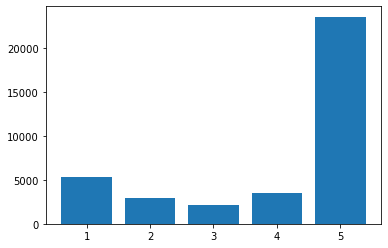

In [4]:
reviews_df = reviews.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first')
plt.bar(reviews_df["Score"].unique(),reviews_df["Score"].value_counts())
plt.show()

Text(0.5, 1.0, 'Labels')

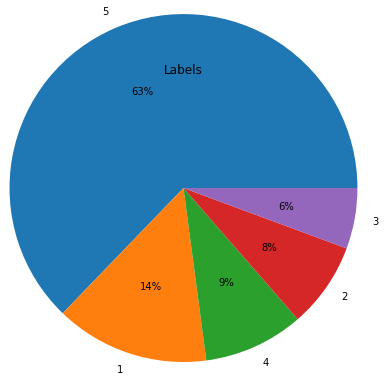

In [5]:
plt.pie(reviews_df["Score"].value_counts(),autopct='%1.0f%%',radius=2,labels=reviews_df["Score"].unique())
plt.title("Labels")

# Data Preprocessing

In [6]:
# Importing Required libraried

#import nltk
#nltk.download('punkt')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#nltk.download('stopwords')

In [18]:
# Removing 'not' from stopwords as not plays a very important role in determining the meaning of the sentence

stop_words = set()
for word in set(stopwords.words('english')):
    if word != 'not':
        stop_words.add(word)

In [19]:
# from the entire dataset separating the columns requirded

reviews_df=reviews_df[["Text","Score"]]

In [20]:
# Creating a function to remove the unwanted things from the review 

def text_Preprocessing(reviews):
        pre_processed_reviews=[]
        for review in tqdm(reviews):
            review= BeautifulSoup(review,'lxml').getText()    #remove html tags
            review=re.sub('\\S*\\d\\S*','',review).strip()
            review=re.sub('[^A-Za-z]+',' ',review)        #remove special chars\n",
            review=re.sub("n't","not",review)
            review=word_tokenize(str(review.lower())) #tokenize the reviews into word tokens
            review=' '.join(PorterStemmer().stem(word) for word in review if word not in stop_words)
            pre_processed_reviews.append(review.strip())
        return pre_processed_reviews

In [10]:
# Calling the function and saving all the reviews in list for further processing

preprocessed_reviews=text_Preprocessing(reviews_df["Text"])

100%|███████████████████████████████████████████████████████████████████████████| 37452/37452 [01:03<00:00, 593.77it/s]


In [12]:
# Viewing any one of the processed review

show = preprocessed_reviews[34]
show

'mccann instant irish oatmeal varieti pack regular appl cinnamon mapl brown sugar box pack fan mccann steel cut oat thought give instant varieti tri found hardi meal not sweet great folk like post bariatr surgeri need food palat easili digest fiber make bloat'

In [21]:
# Count of each rating category

preprocessed_reviews=pd.DataFrame({"text":preprocessed_reviews,"sentiment":reviews_df.Score})
print(preprocessed_reviews.sentiment.value_counts())

5    23515
4     5360
1     3484
3     2980
2     2113
Name: sentiment, dtype: int64


# Corpus Creation

In [22]:
corpus = []
for review in preprocessed_reviews['text']:
    corpus.append(review)

# Creating CountVectorizer

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 6000)
X = cv.fit_transform(corpus).toarray()
Y = preprocessed_reviews.iloc[:, 1].values

# Training the model

In [24]:
# Splitting the dataset into training and test set

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [25]:
# Creating the model and fitting it to the dataset

# Importing Required packages
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB

# Making the classifier with suitable parameters
bg = BaggingClassifier(MultinomialNB(), max_samples = 0.5, max_features = 1.0, n_estimators = 300)

# Fitting the model to the dataset
bg.fit(X_train, Y_train)

BaggingClassifier(base_estimator=MultinomialNB(), max_samples=0.5,
                  n_estimators=300)

# Checking Accuracy

In [26]:
# Accuracy on training set

print(bg.score(X_train, Y_train))

0.7270117819832449


In [27]:
# Accuracy on test set

print(bg.score(X_test, Y_test))

0.6860232278734482


# Confusion Matrix to analyze pedictions

In [28]:
# Predicting 

Y_pred = bg.predict(X_test)

In [29]:
# creating confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_pred)

In [46]:
cm

array([[ 416,   59,   48,   29,  141],
       [ 124,   51,   70,   53,  119],
       [  72,   27,  153,  118,  208],
       [  57,   24,   89,  299,  556],
       [ 130,   41,   82,  305, 4220]], dtype=int64)

# Plotting Cunfusion Matrix for better understanding the models accuracy

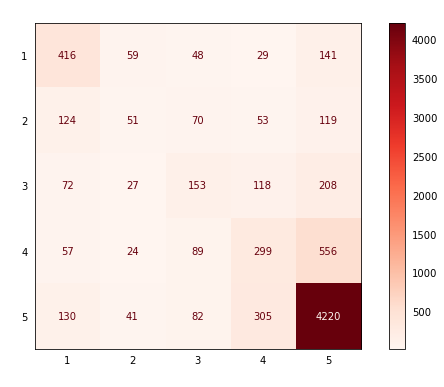

In [44]:
from sklearn.metrics import plot_confusion_matrix

matrix = plot_confusion_matrix(bg, X_test, Y_test, cmap = plt.cm.Reds)
matrix.ax_.set_title('Confusion Matrix', color = 'white')
plt.xlabel('Predicted Label', color = 'white')
plt.ylabel('True Label', color = 'white')
plt.gcf().axes[0].tick_params(color = 'white')
plt.gcf().axes[1].tick_params(color = 'white')
plt.gcf().set_size_inches(10,6)
plt.show()


# Dumping Model and Vectorizer using Pickle module

In [45]:
import pickle

# Dumping Vectorizer
pickle.dump(cv,open("rating_vectorizer.pkl","wb"))

#Dumping BG Model
pickle.dump(bg,open("rating_model.pkl","wb"))

# These pickle files can be used In the Web Application